<a href="https://colab.research.google.com/github/chronicle99/Assignment_1/blob/main/assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone -q https://github.com/vinayakrana/es335-25-fall-assignment-1.git
%cd es335-25-fall-assignment-1

# core libs
!pip -q install numpy pandas matplotlib scikit-learn tsfel


/content/es335-25-fall-assignment-1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 564.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.7 MB/s eta 0:00:00


In [2]:
%%writefile metrics.py
from typing import Union
import pandas as pd

def accuracy(y_hat: pd.Series, y: pd.Series) -> float:

    assert y_hat.size == y.size
    return float((y_hat.reset_index(drop=True) == y.reset_index(drop=True)).mean())

def precision(y_hat: pd.Series, y: pd.Series, cls: Union[int, str]) -> float:
    assert y_hat.size == y.size
    y_hat = y_hat.reset_index(drop=True)
    y = y.reset_index(drop=True)
    tp = ((y_hat == cls) & (y == cls)).sum()
    fp = ((y_hat == cls) & (y != cls)).sum()
    return float(tp / (tp + fp)) if (tp + fp) > 0 else 0.0

def recall(y_hat: pd.Series, y: pd.Series, cls: Union[int, str]) -> float:
    assert y_hat.size == y.size
    y_hat = y_hat.reset_index(drop=True)
    y = y.reset_index(drop=True)
    tp = ((y_hat == cls) & (y == cls)).sum()
    fn = ((y_hat != cls) & (y == cls)).sum()
    return float(tp / (tp + fn)) if (tp + fn) > 0 else 0.0

def rmse(y_hat: pd.Series, y: pd.Series) -> float:
    assert y_hat.size == y.size
    diff = y_hat.reset_index(drop=True) - y.reset_index(drop=True)
    # no numpy import: square via **2, then mean, then square-root via **0.5
    return float(((diff ** 2).mean()) ** 0.5)

def mae(y_hat: pd.Series, y: pd.Series) -> float:
    assert y_hat.size == y.size
    diff = (y_hat.reset_index(drop=True) - y.reset_index(drop=True)).abs()
    return float(diff.mean())


Overwriting metrics.py


now we run the metrics file

In [3]:
%%writefile tree/utils.py
import pandas as pd
import numpy as np

def one_hot_encoding(X: pd.DataFrame) -> pd.DataFrame:
    return pd.get_dummies(X, drop_first=False)

def check_ifreal(y: pd.Series) -> bool:
    return pd.api.types.is_numeric_dtype(y)

def _class_probs(Y: pd.Series):
    counts = Y.value_counts(dropna=False)
    probs = counts / counts.sum()
    return probs.values

def entropy(Y: pd.Series) -> float:
    p = _class_probs(Y)
    p = p[p > 0]
    return float(-(p * np.log2(p)).sum()) if p.size else 0.0

def gini_index(Y: pd.Series) -> float:
    p = _class_probs(Y)
    return float(1.0 - (p**2).sum()) if p.size else 0.0

def _is_numeric(s: pd.Series) -> bool:
    return pd.api.types.is_numeric_dtype(s)

def _variance(Y: pd.Series) -> float:
    if Y.size == 0: return 0.0
    return float(np.var(Y.values, ddof=0))

def _best_numeric_threshold(x: pd.Series, y: pd.Series, criterion: str, is_reg: bool):

    order = np.argsort(x.values)
    x_sorted = x.values[order]
    y_sorted = y.values[order]
    uniq = np.unique(x_sorted)
    if uniq.size <= 1:
        return None, None  # no split
    thresholds = (uniq[:-1] + uniq[1:]) / 2.0

    best_gain, best_thr = -np.inf, None
    for thr in thresholds:
        left_mask = x_sorted <= thr
        yL, yR = y_sorted[left_mask], y_sorted[~left_mask]
        if is_reg:
            base = _variance(pd.Series(y_sorted))
            child = (yL.size/ y_sorted.size)*_variance(pd.Series(yL)) + (yR.size/ y_sorted.size)*_variance(pd.Series(yR))
            gain = base - child
        else:
            if criterion == "gini_index":
                base = gini_index(pd.Series(y_sorted))
                child = (yL.size/ y_sorted.size)*gini_index(pd.Series(yL)) + (yR.size/ y_sorted.size)*gini_index(pd.Series(yR))
                gain = base - child
            else:
                base = entropy(pd.Series(y_sorted))
                child = (yL.size/ y_sorted.size)*entropy(pd.Series(yL)) + (yR.size/ y_sorted.size)*entropy(pd.Series(yR))
                gain = base - child
        if gain > best_gain:
            best_gain, best_thr = float(gain), float(thr)
    return best_gain, best_thr

def information_gain(Y: pd.Series, attr: pd.Series, criterion: str) -> float:
    is_reg = check_ifreal(Y)
    if is_reg:
        base = _variance(Y)
        if _is_numeric(attr):
            gain, thr = _best_numeric_threshold(attr, Y, criterion, True)
            return -np.inf if thr is None else gain
        else:

            total = len(Y)
            child_var = 0.0
            for cat, idx in attr.groupby(attr).groups.items():
                child_var += (len(idx)/total) * _variance(Y.iloc[list(idx)])
            return base - child_var
    else:
        if _is_numeric(attr):
            gain, thr = _best_numeric_threshold(attr, Y, criterion, False)
            return -np.inf if thr is None else gain
        else:
            total = len(Y)
            if criterion == "gini_index":
                base = gini_index(Y)
                child_imp = sum((len(idx)/total)*gini_index(Y.iloc[list(idx)])
                                for _, idx in attr.groupby(attr).groups.items())
            else:
                base = entropy(Y)
                child_imp = sum((len(idx)/total)*entropy(Y.iloc[list(idx)])
                                for _, idx in attr.groupby(attr).groups.items())
            return base - child_imp

def opt_split_attribute(X: pd.DataFrame, y: pd.Series, criterion: str, features: pd.Index):
    is_reg = check_ifreal(y)
    best = {"feat": None, "thr": None, "gain": -np.inf, "is_cat": False, "cat_value": None}
    for feat in features:
        col = X[feat]
        if _is_numeric(col):
            gain, thr = _best_numeric_threshold(col, y, criterion, is_reg)
            if thr is not None and gain > best["gain"]:
                best.update({"feat": feat, "thr": thr, "gain": float(gain), "is_cat": False, "cat_value": None})
        else:

            cats = col.astype("category").cat.categories
            for c in cats:
                mask = (col == c)
                yL, yR = y[mask], y[~mask]
                if is_reg:
                    base = _variance(y)
                    child = (len(yL)/len(y))*_variance(yL) + (len(yR)/len(y))*_variance(yR)
                    gain = base - child
                else:
                    if criterion == "gini_index":
                        base = gini_index(y)
                        child = (len(yL)/len(y))*gini_index(yL) + (len(yR)/len(y))*gini_index(yR)
                        gain = base - child
                    else:
                        base = entropy(y)
                        child = (len(yL)/len(y))*entropy(yL) + (len(yR)/len(y))*entropy(yR)
                        gain = base - child
                if gain > best["gain"]:
                    best.update({"feat": feat, "thr": None, "gain": float(gain), "is_cat": True, "cat_value": c})
    return best

def split_data(X: pd.DataFrame, y: pd.Series, attribute, value, is_cat: bool):
    if is_cat:
        left_mask = (X[attribute] == value)
    else:
        left_mask = (X[attribute] <= value)
    X_left, y_left = X[left_mask], y[left_mask]
    X_right, y_right = X[~left_mask], y[~left_mask]
    return (X_left, y_left), (X_right, y_right)


Overwriting tree/utils.py


In [4]:
%%writefile tree/base.py
from dataclasses import dataclass
from typing import Optional, Literal
import numpy as np
import pandas as pd
from tree.utils import opt_split_attribute, split_data, check_ifreal, one_hot_encoding

@dataclass
class _Node:
    feature: Optional[str] = None
    threshold: Optional[float] = None  # numeric threshold
    is_cat: bool = False
    cat_value: Optional[object] = None
    left: Optional["__class__"] = None
    right: Optional["__class__"] = None
    prediction: Optional[object] = None

class DecisionTree:
    def __init__(self, criterion: Literal["information_gain","gini_index"]="information_gain", max_depth: int = 5, min_samples_split: int = 2):
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
        self._is_reg = None
        self._categorical_cols = None

    def _leaf_value(self, y: pd.Series):
        if self._is_reg:
            return float(y.mean())
        # classification
        return y.mode(dropna=False).iloc[0]

    def fit(self, X: pd.DataFrame, y: pd.Series) -> None:

        self._is_reg = check_ifreal(y)
        # Keep original types (we will split directly on columns; no one-hot here)
        self._categorical_cols = [c for c in X.columns if not pd.api.types.is_numeric_dtype(X[c])]
        self.root = self._build(X.reset_index(drop=True), y.reset_index(drop=True), depth=0)

    def _build(self, X: pd.DataFrame, y: pd.Series, depth: int) -> _Node:
        node = _Node()
        # stopping conditions
        if depth >= self.max_depth or len(X) < self.min_samples_split or y.nunique(dropna=False) == 1 or X.shape[1] == 0:
            node.prediction = self._leaf_value(y)
            return node

        best = opt_split_attribute(X, y, self.criterion, X.columns)
        if best["feat"] is None or best["gain"] <= 0:
            node.prediction = self._leaf_value(y)
            return node

        (XL, yL), (XR, yR) = split_data(X, y, best["feat"], best["cat_value"] if best["is_cat"] else best["thr"], best["is_cat"])
        if len(XL) == 0 or len(XR) == 0:
            node.prediction = self._leaf_value(y)
            return node

        node.feature = best["feat"]
        node.is_cat = best["is_cat"]
        node.threshold = None if best["is_cat"] else float(best["thr"])
        node.cat_value = best["cat_value"]
        node.left = self._build(XL, yL, depth+1)
        node.right = self._build(XR, yR, depth+1)
        return node

    def _predict_row(self, row: pd.Series, node: _Node):
        while node.prediction is None:
            val = row[node.feature]
            if node.is_cat:
                go_left = (val == node.cat_value)
            else:
                go_left = (val <= node.threshold)
            node = node.left if go_left else node.right
        return node.prediction

    def predict(self, X: pd.DataFrame) -> pd.Series:
        preds = [self._predict_row(X.iloc[i], self.root) for i in range(len(X))]
        return pd.Series(preds)

    def plot(self) -> None:
        def _print(node, indent=""):
            if node.prediction is not None:
                print(indent + f"Leaf -> {node.prediction}")
                return
            cond = f"{node.feature} == {node.cat_value}" if node.is_cat else f"{node.feature} <= {node.threshold:.4f}"
            print(indent + f"?({cond})")
            print(indent + "  Y:", end=" "); _print(node.left, indent + "    ")
            print(indent + "  N:", end=" "); _print(node.right, indent + "    ")
        _print(self.root)


Overwriting tree/base.py


In [5]:
"""
The current code given is for the Assignment 1.
You will be expected to use this to make trees for:
> discrete input, discrete output
> real input, real output
> real input, discrete output
> discrete input, real output
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tree.base import DecisionTree
from metrics import *

np.random.seed(42)
# Test case 1
# Real Input and Real Output

N = 30
P = 5
X = pd.DataFrame(np.random.randn(N, P))
y = pd.Series(np.random.randn(N))


for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria)  # Split based on Inf. Gain
    tree.fit(X, y)
    y_hat = tree.predict(X)
    tree.plot()
    print("Criteria :", criteria)
    print("RMSE: ", rmse(y_hat, y))
    print("MAE: ", mae(y_hat, y))

# Test case 2
# Real Input and Discrete Output

N = 30
P = 5
X = pd.DataFrame(np.random.randn(N, P))
y = pd.Series(np.random.randint(P, size=N), dtype="category")

for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria)  # Split based on Inf. Gain
    tree.fit(X, y)
    y_hat = tree.predict(X)
    tree.plot()
    print("Criteria :", criteria)
    print("Accuracy: ", accuracy(y_hat, y))
    for cls in y.unique():
        print("Precision: ", precision(y_hat, y, cls))
        print("Recall: ", recall(y_hat, y, cls))


# Test case 3
# Discrete Input and Discrete Output

N = 30
P = 5
X = pd.DataFrame({i: pd.Series(np.random.randint(P, size=N), dtype="category") for i in range(5)})
y = pd.Series(np.random.randint(P, size=N), dtype="category")

for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria)  # Split based on Inf. Gain
    tree.fit(X, y)
    y_hat = tree.predict(X)
    tree.plot()
    print("Criteria :", criteria)
    print("Accuracy: ", accuracy(y_hat, y))
    for cls in y.unique():
        print("Precision: ", precision(y_hat, y, cls))
        print("Recall: ", recall(y_hat, y, cls))

# Test case 4
# Discrete Input and Real Output

N = 30
P = 5
X = pd.DataFrame({i: pd.Series(np.random.randint(P, size=N), dtype="category") for i in range(5)})
y = pd.Series(np.random.randn(N))

for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria)  # Split based on Inf. Gain
    tree.fit(X, y)
    y_hat = tree.predict(X)
    tree.plot()
    print("Criteria :", criteria)
    print("RMSE: ", rmse(y_hat, y))
    print("MAE: ", mae(y_hat, y))

?(1 <= -1.1940)
  Y:     Leaf -> 2.720169166589619
  N:     ?(4 <= 0.3866)
      Y:         ?(0 <= 1.5078)
          Y:             ?(4 <= -1.7440)
              Y:                 ?(1 <= 0.8125)
                  Y:                     Leaf -> 0.534667267785164
                  N:                     Leaf -> 0.9633761292443218
              N:                 ?(2 <= 1.2407)
                  Y:                     Leaf -> -0.345994377277823
                  N:                     Leaf -> 0.82206015999449
          N:             ?(0 <= 1.8702)
              Y:                 Leaf -> 1.4535340771573169
              N:                 Leaf -> 0.8271832490360238
      N:         ?(0 <= -0.3567)
          Y:             ?(0 <= -0.4905)
              Y:                 ?(0 <= -0.5517)
                  Y:                     Leaf -> 1.8657745111447566
                  N:                     Leaf -> 1.8967929826539474
              N:                 Leaf -> 1.158595579007404
         

In [6]:
import numpy as np, pandas as pd
from tree.base import DecisionTree
from metrics import accuracy, precision, recall, rmse, mae

np.random.seed(42)

# Case A: real X, real y (regression)
N,P=60,5
X = pd.DataFrame(np.random.randn(N,P), columns=[f"x{i}" for i in range(P)])
y = pd.Series(np.random.randn(N))
tree = DecisionTree(criterion="information_gain", max_depth=4)
tree.fit(X,y)
y_hat = tree.predict(X)
print("A) RMSE:", rmse(y_hat,y), "MAE:", mae(y_hat,y))

# Case B: real X, discrete y (classification)
y = pd.Series(np.random.randint(3,size=N), dtype="category")
tree = DecisionTree(criterion="gini_index", max_depth=4)
tree.fit(X,y)
y_hat = tree.predict(X)
print("B) Acc:", accuracy(y_hat,y))
for cls in y.unique():
    print(f"   class {cls}: P={precision(y_hat,y,cls):.3f} R={recall(y_hat,y,cls):.3f}")

# Case C: discrete X, discrete y
Xc = pd.DataFrame({f"c{i}": pd.Series(np.random.randint(4,size=N)).astype("category") for i in range(P)})
y = pd.Series(np.random.randint(3,size=N), dtype="category")
tree = DecisionTree(criterion="information_gain", max_depth=4)
tree.fit(Xc,y)
y_hat = tree.predict(Xc)
print("C) Acc:", accuracy(y_hat,y))

# Case D: discrete X, real y
y = pd.Series(np.random.randn(N))
tree = DecisionTree(criterion="information_gain", max_depth=4)
tree.fit(Xc,y)
y_hat = tree.predict(Xc)
print("D) RMSE:", rmse(y_hat,y), "MAE:", mae(y_hat,y))


A) RMSE: 0.3983967214830425 MAE: 0.3028426814554994
B) Acc: 0.6666666666666666
   class 0: P=0.628 R=0.931
   class 2: P=0.714 R=0.357
   class 1: P=0.800 R=0.471
C) Acc: 0.7333333333333333
D) RMSE: 0.642531683916424 MAE: 0.4655252874157269


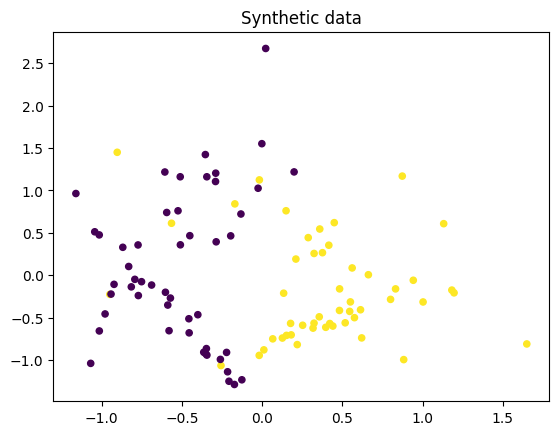

Test Accuracy: 0.8333333333333334
Class 1: Precision = 0.9167, Recall = 0.7333
Class 0: Precision = 0.7778, Recall = 0.9333


In [7]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from tree.base import DecisionTree
from metrics import accuracy, precision, recall

X_np, y_np = make_classification(n_features=2, n_redundant=0, n_informative=2,
                                 random_state=1, n_clusters_per_class=2, class_sep=0.5)
X = pd.DataFrame(X_np, columns=["x1","x2"])
y = pd.Series(y_np).astype("category")

# Plot scatter
plt.figure()
plt.scatter(X["x1"], X["x2"], c=y.astype(int), s=20)
plt.title("Synthetic data")
plt.show()

# 70/30 split
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
tree = DecisionTree(criterion="gini_index", max_depth=4)
tree.fit(Xtr, ytr)
yhat = tree.predict(Xte)

print("Test Accuracy:", accuracy(yhat, yte))
for cls in y.unique():
    print(f"Class {cls}: Precision = {precision(yhat,yte,cls):.4f}, Recall = {recall(yhat,yte,cls):.4f}")


In [8]:
from sklearn.model_selection import KFold
import numpy as np

depth_candidates = list(range(1,9))
outer = KFold(n_splits=5, shuffle=True, random_state=42)

outer_acc = []
chosen_depths = []

for train_idx, test_idx in outer.split(X):
    Xtr, Xte = X.iloc[train_idx], X.iloc[test_idx]
    ytr, yte = y.iloc[train_idx], y.iloc[test_idx]
    inner = KFold(n_splits=5, shuffle=True, random_state=123)

    best_depth, best_score = None, -np.inf
    for d in depth_candidates:
        scores = []
        for itrain, ival in inner.split(Xtr):
            Xi_tr, Xi_val = Xtr.iloc[itrain], Xtr.iloc[ival]
            yi_tr, yi_val = ytr.iloc[itrain], ytr.iloc[ival]
            t = DecisionTree(criterion="gini_index", max_depth=d)
            t.fit(Xi_tr, yi_tr)
            yh = t.predict(Xi_val)
            scores.append(accuracy(yh, yi_val))
        mean_score = np.mean(scores)
        if mean_score > best_score:
            best_score, best_depth = mean_score, d

    chosen_depths.append(best_depth)
    t = DecisionTree(criterion="gini_index", max_depth=best_depth)
    t.fit(Xtr, ytr)
    yh = t.predict(Xte)
    outer_acc.append(accuracy(yh, yte))

print("Chosen depths per outer fold:", chosen_depths)
print("Outer-fold accuracy: mean =", np.mean(outer_acc), "±", np.std(outer_acc))


Chosen depths per outer fold: [1, 4, 1, 2, 2]
Outer-fold accuracy: mean = 0.9 ± 0.06324555320336755


/tmp/ipython-input-138068281.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(url, delim_whitespace=True, names=cols, na_values="?")


Our DT -> RMSE: 3.177161692864121 MAE: 2.303786480970983
sklearn DT -> RMSE: 3.1771616928641215 MAE: 2.303786480970983


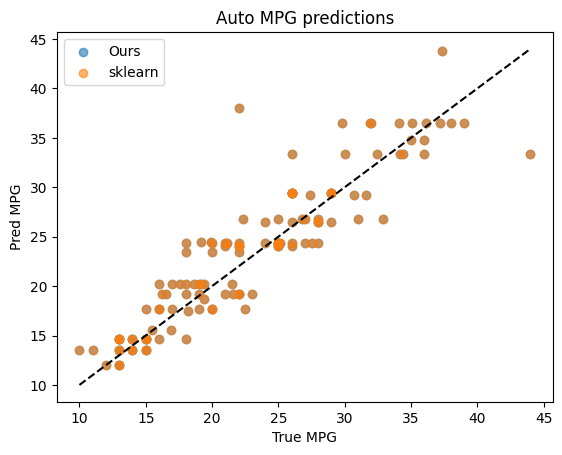

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from metrics import rmse, mae
from tree.base import DecisionTree

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
cols = ["mpg","cylinders","displacement","horsepower","weight","acceleration","model year","origin","car name"]
df = pd.read_csv(url, delim_whitespace=True, names=cols, na_values="?")
df = df.dropna().copy()
df["origin"] = df["origin"].astype("category")
df = df.drop(columns=["car name"])

y = df["mpg"]
X = df.drop(columns=["mpg"])

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=42)

# Our tree (regression)
t = DecisionTree(criterion="information_gain", max_depth=5)
t.fit(Xtr, ytr)
yhat = t.predict(Xte)
print("Our DT -> RMSE:", rmse(yhat, yte), "MAE:", mae(yhat, yte))

# Sklearn tree
sk = DecisionTreeRegressor(random_state=42, max_depth=5)
# Need to encode categoricals for sklearn regressor
Xtr_enc = pd.get_dummies(Xtr, drop_first=False); Xte_enc = pd.get_dummies(Xte, drop_first=False)
# align columns
Xte_enc = Xte_enc.reindex(columns=Xtr_enc.columns, fill_value=0)
sk.fit(Xtr_enc, ytr)
yhat_sk = pd.Series(sk.predict(Xte_enc))
print("sklearn DT -> RMSE:", rmse(yhat_sk, yte), "MAE:", mae(yhat_sk, yte))

plt.figure(); plt.scatter(yte, yhat, alpha=0.6, label="Ours")
plt.scatter(yte, yhat_sk, alpha=0.6, label="sklearn")
plt.plot([yte.min(), yte.max()], [yte.min(), yte.max()], 'k--')
plt.xlabel("True MPG"); plt.ylabel("Pred MPG"); plt.legend(); plt.title("Auto MPG predictions")
plt.show()


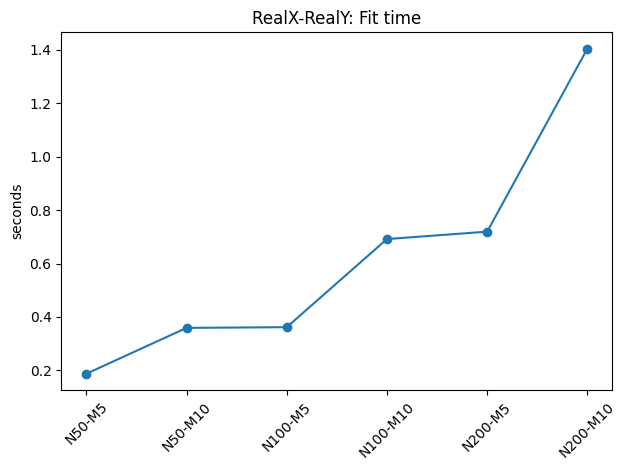

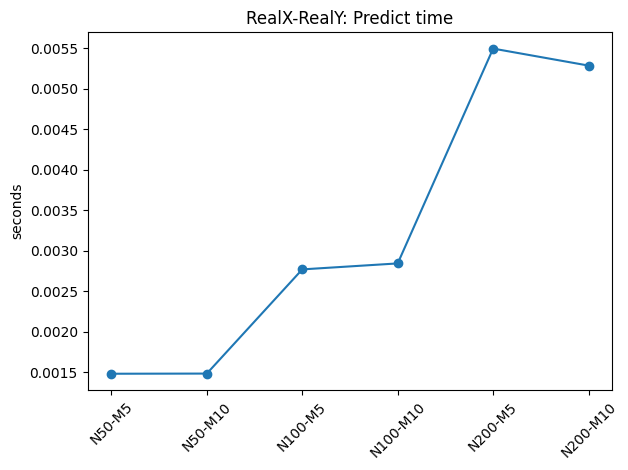

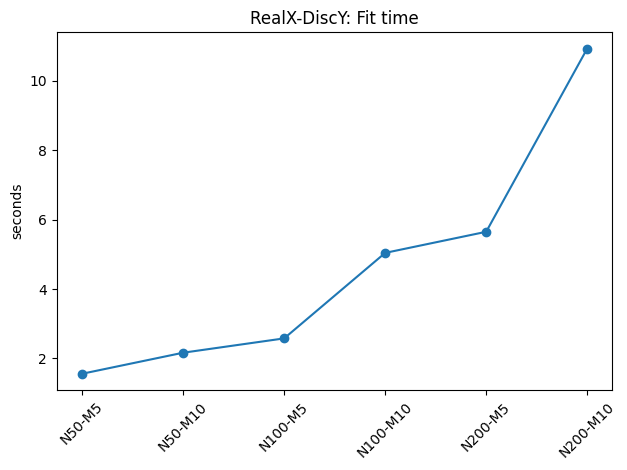

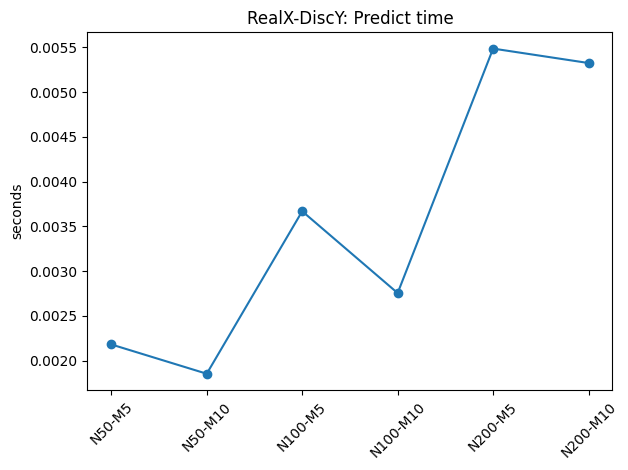

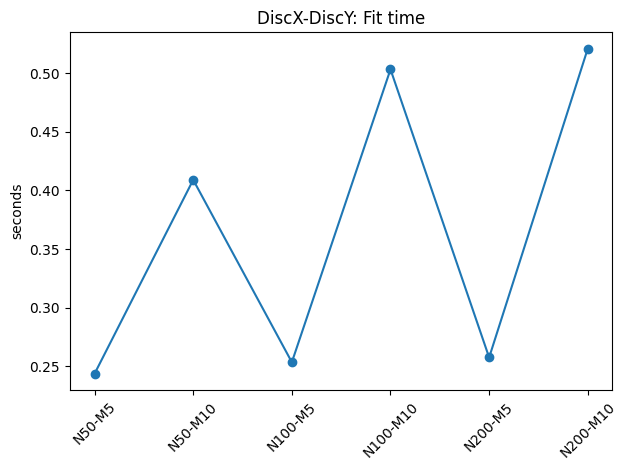

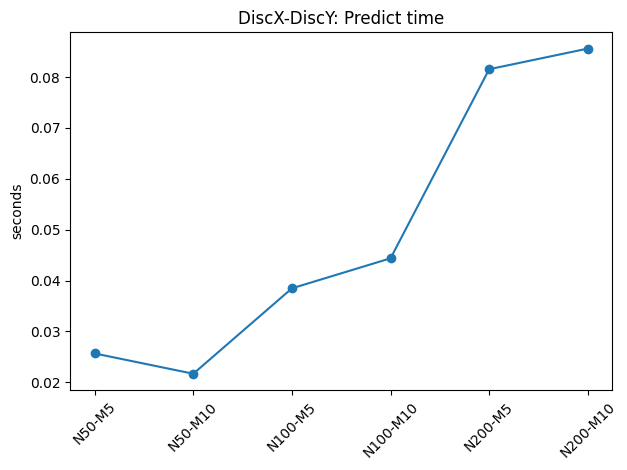

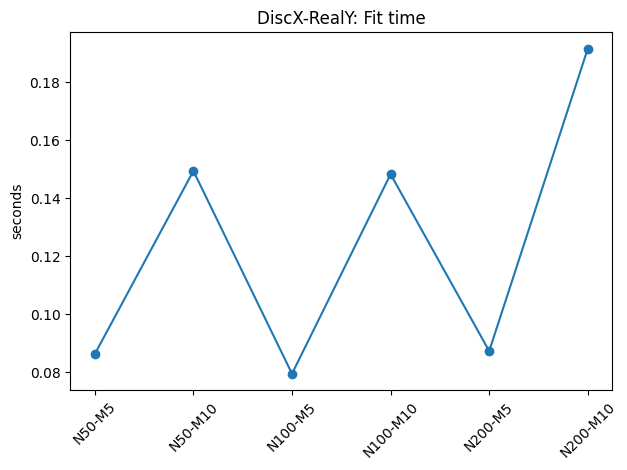

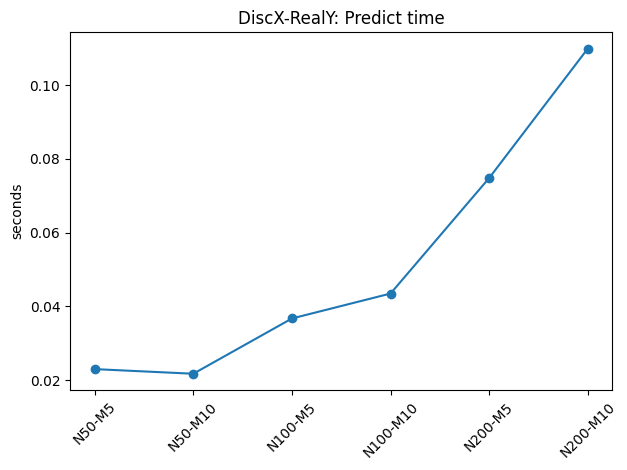

In [10]:
import time, numpy as np, pandas as pd, matplotlib.pyplot as plt
from tree.base import DecisionTree

def make_data(N, M, discrete=False, real_target=False):
    if discrete:
        X = pd.DataFrame({f"c{i}": pd.Series(np.random.randint(2, size=N)).astype("category") for i in range(M)})
    else:
        X = pd.DataFrame(np.random.randn(N, M), columns=[f"x{i}" for i in range(M)])
    if real_target:
        y = pd.Series(np.random.randn(N))
    else:
        y = pd.Series(np.random.randint(2, size=N), dtype="category")
    return X, y

def avg_time_fit_pred(N_values, M_values, case_name, discrete_X, real_y, rep=2, depth=4):
    fitT, predT = [], []
    for N in N_values:
        for M in M_values:
            tf,tp=0.0,0.0
            for _ in range(rep):
                X,y = make_data(N,M, discrete=discrete_X, real_target=real_y)
                t = DecisionTree(criterion="gini_index" if not real_y else "information_gain", max_depth=depth)
                t0 = time.perf_counter(); t.fit(X,y); tf += time.perf_counter()-t0
                t1 = time.perf_counter(); _ = t.predict(X); tp += time.perf_counter()-t1
            fitT.append(tf/rep); predT.append(tp/rep)
    return np.array(fitT), np.array(predT)

N_values=[50,100,200]
M_values=[5,10]

cases = [
    ("RealX-RealY", False, True),
    ("RealX-DiscY", False, False),
    ("DiscX-DiscY", True, False),
    ("DiscX-RealY", True, True),
]

for name, discX, realY in cases:
    fitT, predT = avg_time_fit_pred(N_values, M_values, name, discX, realY)
    xs = [f"N{N}-M{M}" for N in N_values for M in M_values]
    plt.figure(); plt.plot(range(len(xs)), fitT, marker='o'); plt.xticks(range(len(xs)), xs, rotation=45)
    plt.title(f"{name}: Fit time"); plt.ylabel("seconds"); plt.tight_layout(); plt.show()
    plt.figure(); plt.plot(range(len(xs)), predT, marker='o'); plt.xticks(range(len(xs)), xs, rotation=45)
    plt.title(f"{name}: Predict time"); plt.ylabel("seconds"); plt.tight_layout(); plt.show()


In [ ]:
"""
The current code given is for the Assignment 1.
You will be expected to use this to make trees for:
> discrete input, discrete output
> real input, real output
> real input, discrete output
> discrete input, real output
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tree.base import DecisionTree
from metrics import *

np.random.seed(42)
# Test case 1
# Real Input and Real Output

N = 30
P = 5
X = pd.DataFrame(np.random.randn(N, P))
y = pd.Series(np.random.randn(N))


for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria)  # Split based on Inf. Gain
    tree.fit(X, y)
    y_hat = tree.predict(X)
    tree.plot()
    print("Criteria :", criteria)
    print("RMSE: ", rmse(y_hat, y))
    print("MAE: ", mae(y_hat, y))

# Test case 2
# Real Input and Discrete Output

N = 30
P = 5
X = pd.DataFrame(np.random.randn(N, P))
y = pd.Series(np.random.randint(P, size=N), dtype="category")

for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria)  # Split based on Inf. Gain
    tree.fit(X, y)
    y_hat = tree.predict(X)
    tree.plot()
    print("Criteria :", criteria)
    print("Accuracy: ", accuracy(y_hat, y))
    for cls in y.unique():
        print("Precision: ", precision(y_hat, y, cls))
        print("Recall: ", recall(y_hat, y, cls))


# Test case 3
# Discrete Input and Discrete Output

N = 30
P = 5
X = pd.DataFrame({i: pd.Series(np.random.randint(P, size=N), dtype="category") for i in range(5)})
y = pd.Series(np.random.randint(P, size=N), dtype="category")

for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria)  # Split based on Inf. Gain
    tree.fit(X, y)
    y_hat = tree.predict(X)
    tree.plot()
    print("Criteria :", criteria)
    print("Accuracy: ", accuracy(y_hat, y))
    for cls in y.unique():
        print("Precision: ", precision(y_hat, y, cls))
        print("Recall: ", recall(y_hat, y, cls))

# Test case 4
# Discrete Input and Real Output

N = 30
P = 5
X = pd.DataFrame({i: pd.Series(np.random.randint(P, size=N), dtype="category") for i in range(5)})
y = pd.Series(np.random.randn(N))

for criteria in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=criteria)  # Split based on Inf. Gain
    tree.fit(X, y)
    y_hat = tree.predict(X)
    tree.plot()
    print("Criteria :", criteria)
    print("RMSE: ", rmse(y_hat, y))
    print("MAE: ", mae(y_hat, y))

?(1 <= -1.1940)
  Y:     Leaf -> 2.720169166589619
  N:     ?(4 <= 0.3866)
      Y:         ?(0 <= 1.5078)
          Y:             ?(4 <= -1.7440)
              Y:                 ?(1 <= 0.8125)
                  Y:                     Leaf -> 0.534667267785164
                  N:                     Leaf -> 0.9633761292443218
              N:                 ?(2 <= 1.2407)
                  Y:                     Leaf -> -0.345994377277823
                  N:                     Leaf -> 0.82206015999449
          N:             ?(0 <= 1.8702)
              Y:                 Leaf -> 1.4535340771573169
              N:                 Leaf -> 0.8271832490360238
      N:         ?(0 <= -0.3567)
          Y:             ?(0 <= -0.4905)
              Y:                 ?(0 <= -0.5517)
                  Y:                     Leaf -> 1.8657745111447566
                  N:                     Leaf -> 1.8967929826539474
              N:                 Leaf -> 1.158595579007404
         